In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [3]:
library(lme4)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




In [42]:
library(MuMIn)

In [70]:
library(sjstats)

In [41]:
options(mc.cores = 4)

In [2]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [3]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Q1: Is the new table of contents is used more frequently than the previous table of contents


In [7]:
query_click <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  AND year=2022 AND month IN (5,6) 
AND  experiment_name='skin-vector-toc-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki NOT IN ('testwiki','test2wiki')  
AND year=2022 
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
AND  experiment_name='skin-vector-toc-experiment'
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)
-- clicks from ab test group
SELECT t3.event.token AS session_id, 
wiki, event.isanon,  t4.test_group, count(1) AS clicks
FROM event.DesktopWebUIActionsTracking AS t3
INNER JOIN t_ab AS t4 
ON  t3.wiki=t4.wiki AND t3.event.token = t4.web_session_id
WHERE t3.wiki IN ('bnwiki', 'fawiki', 'foundationwiki',
'hewiki', 'ptwikinews', 'ptwikiversity', 'srwiki',
'thwiki', 'vecwiki', 'viwiki', 'viwikibooks', 'dewikivoyage',
'euwiki', 'kowiki', 'plwikinews', 'trwiki', 'arywiki',
'frwiki', 'frwikiquote', 'frwiktionary', 'incubatorwiki', 'ptwiki'
) 
AND t3.year=2022 and t3.month IN (5,6)
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
AND t4.session_dt <= t3.meta.dt
AND event.name = 'ui.toc'
AND event.action='click' AND event.skinversion=2 
GROUP BY t3.event.token, t3.wiki, event.isanon, t4.test_group
"

In [8]:
df_clicks_session2 <- wmfdata::query_hive(query_click)

Don't forget to authenticate with Kerberos using kinit



In [10]:
df <- df_clicks_session2 %>%
  filter(wiki!='foundationwiki')

In [1]:
#df_clicks_session <- read.csv(file ='Data_out/clicks_session.csv', header = TRUE, na.strings=c("NULL") ) 
#head(df_clicks_session )

In [ ]:
df_0<- df_clicks_session %>% 
     filter(wiki!='foundationwiki') %>%
     group_by(web_session_id, wiki, test_group) %>%
     summarize(sum_clicks=sum(clicks))

In [2]:
#df_0<- df_clicks_session %>% 
#     filter(wiki!='foundationwiki') %>%
#     group_by(web_session_id, wiki, test_group) %>%
#     summarize(sum_clicks=sum(clicks))
#head(df_0)

In [11]:
m1 <- glmer( formula = clicks ~ test_group + (1 | wiki),
    family = poisson(link = "log"),
    data = df)

In [12]:
summary(m1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: clicks ~ test_group + (1 | wiki)
   Data: df

      AIC       BIC    logLik  deviance  df.resid 
1001049.4 1001082.2 -500521.7 1001043.4    414942 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
 -0.335  -0.205  -0.195  -0.195 176.734 

Random effects:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.00232  0.04816 
Number of obs: 414945, groups:  wiki, 21

Fixed effects:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          0.240312   0.013170  18.246  < 2e-16 ***
test_grouptreatment -0.021730   0.004377  -4.964 6.89e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
tst_grptrtm -0.005

In [13]:
anova(m1)


,npar,Sum Sq,Mean Sq,F value
,<int>,<dbl>,<dbl>,<dbl>
test_group,1,24.07752,24.07752,24.07752


In [14]:
fixef(m1)


(Intercept) test_grouptreatment 
         0.24031211         -0.02172955

In [17]:
exp(-0.0217295468159615)

[1] 0.9785048

__Note__. 

clicks in treat

In [15]:
confint(m1)


Computing profile confidence intervals ...



,2.5 %,97.5 %
.sig01,0.03262482,0.07633942
(Intercept),0.21125347,0.26950602
test_grouptreatment,-0.03041509,-0.01305601


In [16]:
ranef(m1) 

$wiki
                (Intercept)
arywiki       -0.0018814324
bnwiki         0.0800079900
dewikivoyage  -0.0046582411
euwiki         0.0296842058
fawiki        -0.0406588745
frwiki        -0.0455399557
frwikiquote   -0.0164262434
frwiktionary  -0.0237872139
hewiki        -0.0333779077
incubatorwiki  0.0066097525
kowiki        -0.0287823916
plwikinews    -0.0001993105
ptwiki        -0.0311102718
ptwikinews    -0.0006308284
ptwikiversity -0.0105756294
srwiki         0.0181180202
thwiki         0.0938527250
trwiki         0.0526982085
vecwiki       -0.0018814324
viwiki        -0.0358401554
viwikibooks   -0.0037302360

with conditional variances for “wiki” 

In [39]:
summary(m1)$r.squared 

NULL

In [40]:
summary(m2)$r.squared 

NULL

In [43]:
r.squaredGLMM(m1)

Warning message:
“'r.squaredGLMM' now calculates a revised statistic. See the help page.”
Warning message:
“The null model is correct only if all variables used by the original model remain unchanged.”


,R2m,R2c
delta,6.387064e-05,0.003005925
lognormal,8.646789e-05,0.004069412
trigamma,4.300650e-05,0.002024002


### Model 2: data includes all sessions in AB test with 0 clicks

In [23]:
nrow(filter(df_0, sum_clicks>0))

[1] 414895

In [26]:
nrow(df_0)

[1] 41884231

__Note:__. 

The data has an excess number of zeros.

In [ ]:
m2 <- glmer( formula = sum_clicks ~ test_group + (1 | wiki),
    family = poisson(link = "log"),
    data = df_0)

In [29]:
summary(m2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: sum_clicks ~ test_group + (1 | wiki)
   Data: df_0

     AIC      BIC   logLik deviance df.resid 
 5190307  5190354 -2595151  5190301 41884228 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
  -0.23   -0.14   -0.07   -0.05 2600.54 

Random effects:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 6.575    2.564   
Number of obs: 41884231, groups:  wiki, 23

Fixed effects:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -5.078805   0.002674 -1899.5   <2e-16 ***
test_grouptreatment -2.008637   0.002098  -957.6   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
tst_grptrtm 0.121 
optimizer (Nelder_Mead) convergence code: 0 (OK)
Model failed to converge with max|grad| = 0.0188588 (tol = 0.002, component 1)


In [30]:
anova(m2)

,npar,Sum Sq,Mean Sq,F value
,<int>,<dbl>,<dbl>,<dbl>
test_group,1,213602.7,213602.7,213602.7


In [31]:
fixef(m2)

(Intercept) test_grouptreatment 
          -5.078805           -2.008637

In [32]:
exp(-2.00863695117177)

[1] 0.1341714

In [34]:
confint(m2)

Computing profile confidence intervals ...



ERROR: Error in zeta(shiftpar, start = opt[seqpar1][-w]): profiling detected new, lower deviance


In [ ]:
r2 <- r.squaredGLMM(m2)

Warning message:
“The null model is correct only if all variables used by the original model remain unchanged.”


In [46]:
r2

,R2m,R2c
delta,0.055791073,0.41947651
lognormal,0.100606727,0.75643211
trigamma,0.008463381,0.06363365


__Note:__  
Conditional R squared is 0.75643211. It means 76% of variance is explaned by the model m2. Model m2 is a good fit for the data with 0 clicks. 


p-value <2e-16. coefficient of test_grouptreatment is -2.008637 <0. It means the treatment group with new ToC has fewer clicks on ToC than control group. It contradict our expectation. 

# Q2: Does the new table of contents reduce the need to scroll back to the top of the page


In [35]:
query_scroll_session <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  AND year=2022 AND month IN (5,6) 
AND  experiment_name='skin-vector-toc-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki NOT IN ('testwiki','test2wiki')  
AND year=2022  
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
AND  experiment_name='skin-vector-toc-experiment'
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)

--scrolls by session
SELECT  t_ab.wiki,   t_ab.test_group, t3.is_anon, t3.web_session_id, 
COUNT(1) AS scrolls 
FROM t_ab
LEFT JOIN event.mediawiki_web_ui_scroll AS t3 
ON t_ab.domain=t3.meta.domain AND t3.web_session_id = t_ab.web_session_id
AND t3.year=2022 AND month IN (5,6) 
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
WHERE t_ab.session_dt <= t3.meta.dt
AND t3.action='scroll-to-toc'
GROUP BY  t_ab.wiki,   t_ab.test_group, t3.is_anon, t3.web_session_id

"


In [36]:
df_scroll_session <- wmfdata::query_hive(query_scroll_session)

Don't forget to authenticate with Kerberos using kinit



In [48]:
write_csv(df_scroll_session, "Data_out/scrolls_session.csv")

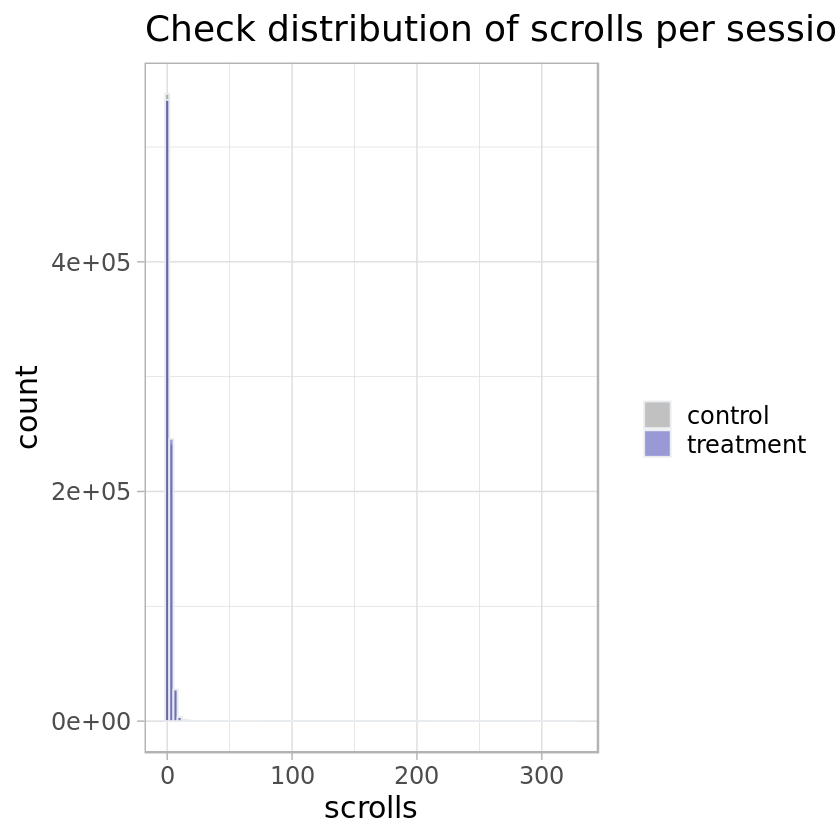

In [49]:
p <- df_scroll_session %>%
 filter(wiki!='foundationwiki') %>%
 ggplot( aes(x=scrolls, fill=test_group)) +
    geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity', bins=100) +
    #scale_x_log10() +
    scale_fill_manual(values=c("#666666", "#000099")) +
    labs ( title = "Check distribution of scrolls per session",
         fill="") +
    theme_light(base_size=18)
p

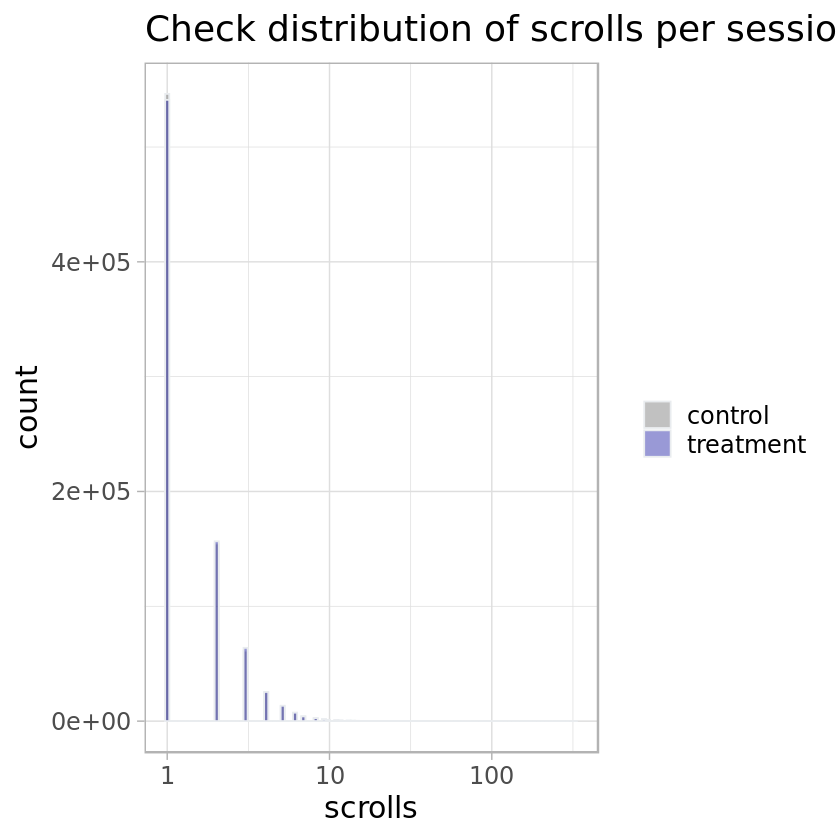

In [50]:
p_log <- df_scroll_session %>%
 filter(wiki!='foundationwiki') %>%
 ggplot( aes(x=scrolls, fill=test_group)) +
    geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity', bins=100) +
    scale_x_log10() +
    scale_fill_manual(values=c("#666666", "#000099")) +
    labs ( title = "Check distribution of scrolls per session (in Log)",
         fill="") +
    theme_light(base_size=18)
p_log

In [51]:
summary(filter(df_scroll_session,test_group=='control' & wiki!='foundationwiki'))

     wiki            test_group          is_anon          web_session_id    
 Length:819845      Length:819845      Length:819845      Length:819845     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
    scrolls       
 Min.   :  1.000  
 1st Qu.:  1.000  
 Median :  1.000  
 Mean   :  1.672  
 3rd Qu.:  2.000  
 Max.   :328.000  

In [52]:
summary(filter(df_scroll_session,test_group=='treatment' & wiki!='foundationwiki'))

     wiki            test_group          is_anon          web_session_id    
 Length:820392      Length:820392      Length:820392      Length:820392     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
    scrolls       
 Min.   :  1.000  
 1st Qu.:  1.000  
 Median :  1.000  
 Mean   :  1.687  
 3rd Qu.:  2.000  
 Max.   :115.000  

__Note:__

After exclulde foundationwiki, the bucketing of control group and treatment group is balanced. 

In [54]:
summary(filter(df_scroll_session,scrolls==0 & wiki!='foundationwiki'))

     wiki            test_group          is_anon          web_session_id    
 Length:0           Length:0           Length:0           Length:0          
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
    scrolls   
 Min.   : NA  
 1st Qu.: NA  
 Median : NA  
 Mean   :NaN  
 3rd Qu.: NA  
 Max.   : NA  

__Note:__

All sessions have at least 1 scroll

In [61]:
df_s_loggedin <- df_scroll_session %>%
    filter(wiki!='foundationwiki'& is_anon=='false')

In [62]:
summary(df_s_loggedin)

     wiki            test_group          is_anon          web_session_id    
 Length:62779       Length:62779       Length:62779       Length:62779      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
    scrolls       
 Min.   :  1.000  
 1st Qu.:  1.000  
 Median :  2.000  
 Mean   :  2.568  
 3rd Qu.:  3.000  
 Max.   :149.000  

In [63]:
df_s_anon <- df_scroll_session %>%
    filter(wiki!='foundationwiki'& is_anon=='true')

In [64]:
summary(df_s_anon)

     wiki            test_group          is_anon          web_session_id    
 Length:1577458     Length:1577458     Length:1577458     Length:1577458    
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
    scrolls       
 Min.   :  1.000  
 1st Qu.:  1.000  
 Median :  1.000  
 Mean   :  1.644  
 3rd Qu.:  2.000  
 Max.   :328.000  

In [65]:
m1_s_loggedin <- glmer( formula = scrolls ~ test_group + (1 | wiki),
    family = poisson(link = "log"),
    data = df_s_loggedin)

In [66]:
summary(m1_s_loggedin)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: scrolls ~ test_group + (1 | wiki)
   Data: df_s_loggedin

      AIC       BIC    logLik  deviance  df.resid 
 292160.2  292187.3 -146077.1  292154.2     62776 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-1.434 -1.010 -0.537  0.221 97.146 

Random effects:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.03943  0.1986  
Number of obs: 62779, groups:  wiki, 23

Fixed effects:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          0.902794   0.045520  19.833   <2e-16 ***
test_grouptreatment -0.008601   0.004989  -1.724   0.0847 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
tst_grptrtm -0.054

__Summary__.   
For logged-in users, 
coef of treatment group = -0.008601, p-value= 0.0847 > 0.05.  We cannot rejected null hypothesis that treatment group and control group have same level of scrolls back to ToC. 

We don't have data to suppport that the new table of contents reduce the need to scroll back to the top of the page for logged-in users. 

In [67]:
m1_s_anon <- glmer( formula = scrolls ~ test_group + (1 | wiki),
    family = poisson(link = "log"),
    data = df_s_anon)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?”


In [68]:
summary(m1_s_anon)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: scrolls ~ test_group + (1 | wiki)
   Data: df_s_anon

     AIC      BIC   logLik deviance df.resid 
 4754411  4754447 -2377202  4754405  1577455 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
 -0.788  -0.476  -0.466   0.314 259.144 

Random effects:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.01678  0.1295  
Number of obs: 1577458, groups:  wiki, 23

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         0.479536   0.016378  29.279  < 2e-16 ***
test_grouptreatment 0.010148   0.001241   8.175 2.96e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
tst_grptrtm -0.017
optimizer (Nelder_Mead) convergence code: 0 (OK)
Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?


nAGQ refers to "the number of points per axis for evaluating the adaptive Gauss-Hermite approximation to the log-likelihood". The n in the acronym stands for number of points, while the AGQ stands for Adaptive Gauss-Hermite Quadrature.
setting nAGQ = 0 is less accurate than setting nAGQ = 1 (the default)

ref: https://stats.stackexchange.com/questions/544937/when-is-it-appropriate-to-set-nagq-0-in-glmer

In [75]:
m2_s_anon <- glmer( formula = scrolls ~ test_group + (1 | wiki),
    family = poisson(link = "log"),
    data = df_s_anon,
    nAGQ = 0)

In [76]:
summary(m2_s_anon)

Generalized linear mixed model fit by maximum likelihood (Adaptive
  Gauss-Hermite Quadrature, nAGQ = 0) [glmerMod]
 Family: poisson  ( log )
Formula: scrolls ~ test_group + (1 | wiki)
   Data: df_s_anon

     AIC      BIC   logLik deviance df.resid 
 4754411  4754447 -2377202  4754405  1577455 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
 -0.788  -0.476  -0.466   0.314 259.144 

Random effects:
 Groups Name        Variance Std.Dev.
 wiki   (Intercept) 0.01678  0.1295  
Number of obs: 1577458, groups:  wiki, 23

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         0.480077   0.029663  16.184  < 2e-16 ***
test_grouptreatment 0.010147   0.001242   8.169 3.11e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
tst_grptrtm -0.021

__Summary__.  

For anonymous users, sessions with new ToC has more scrolls back to ToC. It contradict our expectation.  